# DISCLAIMER

**This isn't my finest work but a basic simulation and streamlit app thrown together a day before deadline, I did this because I thought would be interesting to do and could lead to some cool visualisations for the assignment report**


---

# **Simulating my climate game:** 
**https://docs.google.com/document/d/1tJWnz3HHwFr0vCLX9vjgdrN7TkcHYmGK_M03o42I3Zw/edit?tab=t.sk0jy4ynmiir#heading=h.e5eaa2o7yc29**
link to document explaining the theory of the game



## **Outline**
### **0. Which Data best represents country specific parameters/variables?**
   - Which real world data best maps to country specifc parameters/variablesin the model?, 
   for instance what data best measures fossil fuel dependancy in the economy? cost per unit of switching to renewables, etc.

### **1. Importing and Cleaning Data**
   - Retrieve chosen data proxies for key variables in the model from the worldbank
   - Clean and do basic analysis of the distributions to prevent any model breaking errors when we define our equations

### **2. Defining the Payoff Structure**

   - Static Elements
   - Dynamic Elements
   - Parameters

### **3. Defining Game mechanisms (round looping, player decisions, etc)**
   - Round looping function
   - Storage of round to round variabels and params for visualisaton
   - Player Decision Logic                     





.

---

# **Data for country specific parameters and variables**


### Country-Specific Variables in the Climate Catastrophe Game

| Variable Name        | Description                                                                                  |
|----------------------|----------------------------------------------------------------------------------------------|
| `GDP_i`              | Gross Domestic Product of country *i*, representing economic capacity and investment ability |
| `Energy_Usage_i`     | Total energy consumption of country *i*, capturing energy scale and emissions contribution   |
| `Fossil_Share_i`     | Percentage of energy derived from fossil fuels in country *i*                                |
| `EconomicGains_i`    | Estimated domestic economic benefits from green energy (e.g., jobs, industry growth)         |
| `ClimatePayoff_i`    | Benefit from avoiding climate catastrophe, varies by vulnerability or exposure               |
| `S_i`                | Country *i*'s contribution score: `S_i = α * GDP_i + β * Energy_Usage_i`                      |
| `C0_i`               | Initial adoption cost: `C0_i = α * GDP_i * (1 + Fossil_Share_i / 100)`                        |
| `C_t_i`              | Dynamic adoption cost at round *t*: `C_t_i = C0_i * (1 - Z * W_t)`                            |
| `Pressure_t_i`       | Pressure on country *i* to adopt, increasing with global adoption `W_t`                       |
| `G_i`                | Strategy decision for country *i*: `1 = adopt`, `0 = free-ride`                               |

### *How do I represent these with world bank data?*


`GDP_i` - pretty self explanatory I used a GDP data

`Energy_Usage_i` - calculated from Energy Usage (barrels of oil per capita)  * population

`Fossil_Share_i` - Fossil Fuel energy consumption (% of total)

`EconomicGains_i` - Composite of high GDP per capita, high capital formation and low alpha_i (carbon intensity per dollar of GDP)

`ClimatePayoff_i` - Derived from the Notre Dame Climate Vulnerability Index score and GDP - higher payoff for countries with large economies who are at high risk

`S_i (influence)` - Weighted combination of normalised GDP, normalised energy usage and investment as a % of global output

`C0_i` - Computed from GDP_norm, Fossil_Share and alpha (a param penalising high carbon intensive countries, using carbon intensity per dollar of GDP to define the param per country)

`alpha_i` - Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP) – proxy for carbon efficiency

`Pressure_0` - Function of GDP_norm and alpha_i, representing the baseline of how a country is to be affected by political pressure and trade penalities by adopters

`G_i` - Binary strategic choice endogenously computed based on payoffs


.

---

# **Importing and Cleaning**

In [20]:
#using functions from another project
import pandas as pd
import re
def import_melt(file_path, sheet_name=0):
    
    if file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df.columns = df.columns.str.strip()
        
        #weird year naming
        year_cols = {col: col.split()[0] for col in df.columns if re.match(r'^\d{4} \[YR\d{4}\]$', col)}
        df.rename(columns=year_cols, inplace=True)

        df_long = df.melt(
        id_vars=['Country Name', 'Series Name', 'Country Code', "Series Code"], 
        var_name='Year',  
        value_name='Value')

 
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path, skiprows=4)
        #there was an uneeded colum in the end of all csvs downloaded from the worldbank
        df.drop(columns=[col for col in df.columns if 'Unnamed' in col], inplace=True, errors='ignore')
        #naming schems for the csv year cols were much nicer
        year_cols = [col for col in df.columns if col.isdigit()]
        df_long = df.melt(
        id_vars=['Country Name', 'Indicator Name', 'Country Code', "Indicator Code"], 
        var_name='Year',  
        value_name='Value')
    #now I can import and melt long any CSV or XLSX file from the world bank database because the formatting is all the same for all (im pretty sure) of them differing only by XLSX or CSV
    #surely this will be useful at some point down the line
  

    else:
        raise ValueError("Unsupported file format")
    
    return df_long




c_df = import_melt("climate_data.xlsx")
c_df.head()


# pivoting into more usable data so instead of it being like a whole coloumn that holds the indicator name and then an associated value row, now its just the indicator as a column
c_df = c_df.drop_duplicates()
c_df = c_df.pivot(
    index=['Country Name', 'Country Code', 'Year'],  #
    columns='Series Name',  
    values='Value'  
).reset_index()
c_df.dropna(subset=['Country Name'], inplace=True)
c_df = c_df.loc[:, c_df.notna().any()]  

c_df.head()


v_df = pd.read_csv("vulnerability.csv")
v_df.head()

# Rename the column to match the Country Code for merging
v_df = v_df.rename(columns={"ISO3": "Country Code"})
v_df = v_df.rename(columns={"Name": "Country Name"})

import pandas as pd

# Assuming v_df is your original dataframe with vulnerability data and years as columns
# First, rename the 'ISO3' column to 'Country Code' for consistency
v_df = v_df.rename(columns={"ISO3": "Country Code"})

# Melt the DataFrame from wide to long format
v_df_long = pd.melt(v_df, 
                    id_vars=["Country Code", "Country Name"],  # Keep Country Code and Name as identifiers
                    var_name="Year",            # Name the new column for years
                    value_name="Vulnerability Score")  # Name the new column for the vulnerability values

# Merging v_df_long with c_df on 'Country Code'
c_df = c_df.merge(v_df_long[['Country Code', 'Vulnerability Score']], 
                       on='Country Code', 
                       how='left')

# Display the merged DataFrame to confirm the join
c_df.head()


c_df.columns

Index(['Country Name', 'Country Code', 'Year',
       'Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)',
       'Electricity production from renewable sources, excluding hydroelectric (% of total)',
       'Energy use (kg of oil equivalent per capita)',
       'Fossil fuel energy consumption (% of total)',
       'GDP (constant 2015 US$)', 'Gross capital formation (% of GDP)',
       'Gross capital formation (annual % growth)',
       'Gross capital formation (constant 2015 US$)', 'Population, total',
       'Vulnerability Score'],
      dtype='object')

In [21]:
import matplotlib.pyplot as plt


#define year range
startyear, endyear = 2010, 2015
#convert year to integer
c_df["Year"] = c_df["Year"].astype(int)
#filter dataset to selected range
c_df_range = c_df[(c_df["Year"] >= startyear) & (c_df["Year"] <= endyear)]

#filter dataset to selected range
c_df_range = c_df[(c_df["Year"] >= startyear) & (c_df["Year"] <= endyear)]

#identify non-id columns
nonidcolumns = [col for col in c_df_range.columns if col not in ["Country Name", "Country Code", "Year"]]

#calculate missing percentages
missingpercentages = c_df_range[nonidcolumns].apply(
    lambda x: ((x.astype(str) == "..") | (x == 0) | (x.isna())).sum() / len(x) * 100
)

#filter indicators with missing values
missingpercentages = missingpercentages[missingpercentages > 0].sort_values(ascending=False)

missingpercentages



Fossil fuel energy consumption (% of total)                                            57.174312
Energy use (kg of oil equivalent per capita)                                           57.128440
Electricity production from renewable sources, excluding hydroelectric (% of total)    45.192661
Gross capital formation (annual % growth)                                              22.357798
Gross capital formation (constant 2015 US$)                                            18.917431
Gross capital formation (% of GDP)                                                     14.972477
Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)                          6.651376
Vulnerability Score                                                                     3.926606
GDP (constant 2015 US$)                                                                 1.880734
Population, total                                                                       0.018349
dtype: float64

### **Missing Energy Data**

Nations that track renewable energy data are likely more sustainability-conscious, introducing bias if imputation is based on GDP per capita or regional averages. To avoid overestimating renewable adoption, we use **flat conservative imputation**:

- **Fossil fuel consumption (%)** → Impute missing values with **98%**.
- **Renewable electricity production (excluding hydro) (%)** → Impute missing values with **2%**.

This ensures a realistic approximation without artificially inflating green energy adoption in countries that do not report these metrics.

I think a mean based imputation would work better for the Energy consumption, if we group by gdp per capita


In [22]:
#convert year to integer
import pandas as pd
c_df["Year"] = c_df["Year"].astype(int)

#replace ".." with NaN for proper numerical processing
c_df.replace("..", float("nan"), inplace=True)

#convert necessary columns to numeric (handles non-numeric entries like "..")
c_df["GDP (constant 2015 US$)"] = pd.to_numeric(c_df["GDP (constant 2015 US$)"], errors="coerce")
c_df["Population, total"] = pd.to_numeric(c_df["Population, total"], errors="coerce")

#drop rows where either GDP or Population is missing
c_df = c_df.dropna(subset=["GDP (constant 2015 US$)", "Population, total"]).copy()

#calculate gdp per capita
c_df.loc[:, "GDP per capita"] = c_df["GDP (constant 2015 US$)"] / c_df["Population, total"]

#assign gdp per capita quartiles
c_df.loc[:, "gdp_per_capita_group"] = pd.qcut(c_df["GDP per capita"], q=4, labels=["low", "lower_middle", "upper_middle", "high"])

#calculate mean energy use per gdp group
energy_means = c_df.groupby("gdp_per_capita_group")["Energy use (kg of oil equivalent per capita)"].mean()

#impute missing energy use with group mean
c_df.loc[:, "Energy use (kg of oil equivalent per capita)"] = c_df.apply(
    lambda row: energy_means[row["gdp_per_capita_group"]] if pd.isna(row["Energy use (kg of oil equivalent per capita)"]) else row["Energy use (kg of oil equivalent per capita)"],
    axis=1
)

#replace missing fossil fuel % with a high estimate (85%)
c_df.loc[:, "Fossil fuel energy consumption (% of total)"] = pd.to_numeric(
    c_df["Fossil fuel energy consumption (% of total)"], errors="coerce"
).fillna(98)

#replace missing renewables % with a low estimate (10%)
c_df.loc[:, "Electricity production from renewable sources, excluding hydroelectric (% of total)"] = pd.to_numeric(
    c_df["Electricity production from renewable sources, excluding hydroelectric (% of total)"], errors="coerce"
).fillna(2)



#filter dataset to selected range
c_df_range = c_df[(c_df["Year"] >= startyear) & (c_df["Year"] <= endyear)].copy()


#calculate missing percentages
missingpercentages = c_df_range[nonidcolumns].apply(
    lambda x: ((x.astype(str) == "..") | (x == 0) | (x.isna())).sum() / len(x) * 100
)

#filter indicators with missing values
missingpercentages = missingpercentages[missingpercentages > 0].sort_values(ascending=False)
missingpercentages


/tmp/ipykernel_4056/1187407642.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  c_df.replace("..", float("nan"), inplace=True)
/tmp/ipykernel_4056/1187407642.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  energy_means = c_df.groupby("gdp_per_capita_group")["Energy use (kg of oil equivalent per capita)"].mean()


Gross capital formation (annual % growth)                                              21.131370
Gross capital formation (constant 2015 US$)                                            17.363254
Electricity production from renewable sources, excluding hydroelectric (% of total)    15.726975
Gross capital formation (% of GDP)                                                     13.613838
Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)                          4.862085
Vulnerability Score                                                                     3.655914
dtype: float64

### Due to time constraints on this assignment GEN-AI was used to speed up the process at parts below is prime example

In [ ]:
import numpy as np

#ensure working with c_df_range, not c_df
c_df_range = c_df[(c_df["Year"] >= startyear) & (c_df["Year"] <= endyear)].copy()

#convert necessary columns to numeric
numeric_cols = [
    "GDP (constant 2015 US$)", "Population, total", "Energy use (kg of oil equivalent per capita)", 
    "Gross capital formation (% of GDP)", "Gross capital formation (constant 2015 US$)", 
    "Gross capital formation (annual % growth)", 
    "Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"
]
c_df_range[numeric_cols] = c_df_range[numeric_cols].apply(pd.to_numeric, errors="coerce")

#calculate GDP per capita (only for filtered range)
c_df_range["GDP per capita"] = c_df_range["GDP (constant 2015 US$)"] / c_df_range["Population, total"]

#drop rows where GDP per capita couldn't be calculated
c_df_range = c_df_range.dropna(subset=["GDP per capita"]).copy()


### FIX 1: Forward-fill Gross Capital Formation (Annual % Growth) within Countries
c_df_range.sort_values(["Country Name", "Year"], inplace=True)
c_df_range["Gross capital formation (annual % growth)"] = c_df_range.groupby("Country Name")["Gross capital formation (annual % growth)"].ffill()

# Impute remaining missing values using GDP per capita quartile median
gcf_growth_medians = c_df_range.groupby("gdp_per_capita_group")["Gross capital formation (annual % growth)"].transform("median")
c_df_range["Gross capital formation (annual % growth)"] = c_df_range["Gross capital formation (annual % growth)"].fillna(gcf_growth_medians)

### FIX 2: Recalculate Gross Capital Formation (Constant US$) from % of GDP
c_df_range["Gross capital formation (constant 2015 US$)"] = c_df_range.apply(
    lambda row: row["GDP (constant 2015 US$)"] * (row["Gross capital formation (% of GDP)"] / 100) 
    if pd.notna(row["Gross capital formation (% of GDP)"]) else row["Gross capital formation (constant 2015 US$)"], 
    axis=1
)

# Impute remaining values using GDP per capita quartile median
gcf_usd_medians = c_df_range.groupby("gdp_per_capita_group")["Gross capital formation (constant 2015 US$)"].transform("median")
c_df_range["Gross capital formation (constant 2015 US$)"] = c_df_range["Gross capital formation (constant 2015 US$)"].fillna(gcf_usd_medians)

### FIX 3: Impute Gross Capital Formation (% of GDP) using GDP per capita quartile median
gcf_gdp_medians = c_df_range.groupby("gdp_per_capita_group")["Gross capital formation (% of GDP)"].transform("median")
c_df_range["Gross capital formation (% of GDP)"] = c_df_range["Gross capital formation (% of GDP)"].fillna(gcf_gdp_medians)

### FIX 4: Multi-Level Imputation for Carbon Intensity of GDP
carbon_intensity_medians_gdp = c_df_range.groupby("gdp_per_capita_group")["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"].median()
carbon_intensity_medians_region = c_df_range.groupby("Country Code")["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"].median()
global_carbon_intensity_median = c_df_range["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"].median()

def impute_carbon_intensity(row):
    if pd.notna(row["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"]):
        return row["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"]
    elif row["gdp_per_capita_group"] in carbon_intensity_medians_gdp:
        return carbon_intensity_medians_gdp[row["gdp_per_capita_group"]]
    elif row["Country Code"] in carbon_intensity_medians_region:
        return carbon_intensity_medians_region[row["Country Code"]]
    else:
        return global_carbon_intensity_median

c_df_range["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"] = c_df_range.apply(impute_carbon_intensity, axis=1)

### FIX 5: Ensure Renewables are Filled with 10%
c_df_range["Electricity production from renewable sources, excluding hydroelectric (% of total)"] = c_df_range["Electricity production from renewable sources, excluding hydroelectric (% of total)"].fillna(10)

# Check Remaining Missing Values
missingpercentages = c_df_range[numeric_cols].apply(
    lambda x: ((x.astype(str) == "..") | (x == 0) | (x.isna())).sum() / len(x) * 100
)

# 6. Forward-fill Vulnerability Score, if still missing, impute by income group mean

# Forward-fill Vulnerability Score within countries
c_df_range.sort_values(["Country Name", "Year"], inplace=True)
c_df_range["Vulnerability Score"] = c_df_range.groupby("Country Name")["Vulnerability Score"].ffill()

# If there are still missing values after forward-fill, impute by income group mean
vulnerability_group_means = c_df_range.groupby("gdp_per_capita_group")["Vulnerability Score"].transform("mean")
c_df_range["Vulnerability Score"] = c_df_range["Vulnerability Score"].fillna(vulnerability_group_means)




print("Remaining Missing Data (%):")
print(missingpercentages)
c_df_range.head()

/tmp/ipykernel_4056/4240501750.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gcf_growth_medians = c_df_range.groupby("gdp_per_capita_group")["Gross capital formation (annual % growth)"].transform("median")
/tmp/ipykernel_4056/4240501750.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gcf_usd_medians = c_df_range.groupby("gdp_per_capita_group")["Gross capital formation (constant 2015 US$)"].transform("median")
/tmp/ipykernel_4056/4240501750.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

Remaining Missing Data (%):
GDP (constant 2015 US$)                                           0.000000
Population, total                                                 0.000000
Energy use (kg of oil equivalent per capita)                      0.000000
Gross capital formation (% of GDP)                                0.000000
Gross capital formation (constant 2015 US$)                       0.000000
Gross capital formation (annual % growth)                         0.000000
Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)    1.851332
dtype: float64


/tmp/ipykernel_4056/4240501750.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vulnerability_group_means = c_df_range.groupby("gdp_per_capita_group")["Vulnerability Score"].transform("mean")


,Country Name,Country Code,Year,Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP),"Electricity production from renewable sources, excluding hydroelectric (% of total)",Energy use (kg of oil equivalent per capita),Fossil fuel energy consumption (% of total),GDP (constant 2015 US$),Gross capital formation (% of GDP),Gross capital formation (annual % growth),Gross capital formation (constant 2015 US$),"Population, total",Vulnerability Score,GDP per capita,gdp_per_capita_group
56,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.613711,575.146246,low
57,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.613838,575.146246,low
58,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.613954,575.146246,low
59,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.612246,575.146246,low
60,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.610850,575.146246,low


In [7]:

# List of known non-country groups (regions, economic classifications, etc.)
non_countries = [
    "Africa Eastern and Southern", "Africa Western and Central", "Arab World", "Caribbean small states",
    "Central Europe and the Baltics", "Early-demographic dividend", "East Asia & Pacific",
    "East Asia & Pacific (IDA & IBRD countries)", "East Asia & Pacific (excluding high income)",
    "Euro area", "Europe & Central Asia", "Europe & Central Asia (IDA & IBRD countries)",
    "Europe & Central Asia (excluding high income)", "European Union", "Fragile and conflict affected situations",
    "Heavily indebted poor countries (HIPC)", "High income", "IBRD only", "IDA & IBRD total", "IDA blend",
    "IDA only", "IDA total", "Late-demographic dividend", "Latin America & Caribbean",
    "Latin America & Caribbean (excluding high income)",
    "Latin America & the Caribbean (IDA & IBRD countries)",
    "Least developed countries: UN classification", "Low & middle income", "Low income", "Lower middle income",
    "Middle East & North Africa", "Middle East & North Africa (IDA & IBRD countries)",
    "Middle East & North Africa (excluding high income)", "Middle income",
    "North America", "OECD members", "Other small states", "Pacific island small states",
    "Post-demographic dividend", "Pre-demographic dividend", "Small states", "South Asia",
    "South Asia (IDA & IBRD)", "Sub-Saharan Africa", "Sub-Saharan Africa (IDA & IBRD countries)",
    "Sub-Saharan Africa (excluding high income)", "Upper middle income", "World", "Caribbean"
]

# Filter out non-countries
filtered_df = c_df_range[~c_df_range["Country Name"].isin(non_countries)]

# Count unique countries
num_countries = filtered_df["Country Name"].nunique()
print("Number of unique actual countries:", num_countries)

filtered_df.head()
print(filtered_df.isna().sum())
filtered_df.head()
filtered_df["energy_usage"] = filtered_df["Energy use (kg of oil equivalent per capita)"] * filtered_df["Population, total"]
filtered_df.head()

Number of unique actual countries: 211
Country Name                                                                           0
Country Code                                                                           0
Year                                                                                   0
Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)                         0
Electricity production from renewable sources, excluding hydroelectric (% of total)    0
Energy use (kg of oil equivalent per capita)                                           0
Fossil fuel energy consumption (% of total)                                            0
GDP (constant 2015 US$)                                                                0
Gross capital formation (% of GDP)                                                     0
Gross capital formation (annual % growth)                                              0
Gross capital formation (constant 2015 US$)                            

/tmp/ipykernel_4056/3178721734.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["energy_usage"] = filtered_df["Energy use (kg of oil equivalent per capita)"] * filtered_df["Population, total"]


,Country Name,Country Code,Year,Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP),"Electricity production from renewable sources, excluding hydroelectric (% of total)",Energy use (kg of oil equivalent per capita),Fossil fuel energy consumption (% of total),GDP (constant 2015 US$),Gross capital formation (% of GDP),Gross capital formation (annual % growth),Gross capital formation (constant 2015 US$),"Population, total",Vulnerability Score,GDP per capita,gdp_per_capita_group,energy_usage
56,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.613711,575.146246,low,1.726577e+10
57,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.613838,575.146246,low,1.726577e+10
58,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.613954,575.146246,low,1.726577e+10
59,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.612246,575.146246,low,1.726577e+10
60,Afghanistan,AFG,2014,0.414925,2.0,526.515421,98.0,1.886050e+10,24.163367,6.954887,2.446039e+09,32792523.0,0.610850,575.146246,low,1.726577e+10


# Distributions of Data

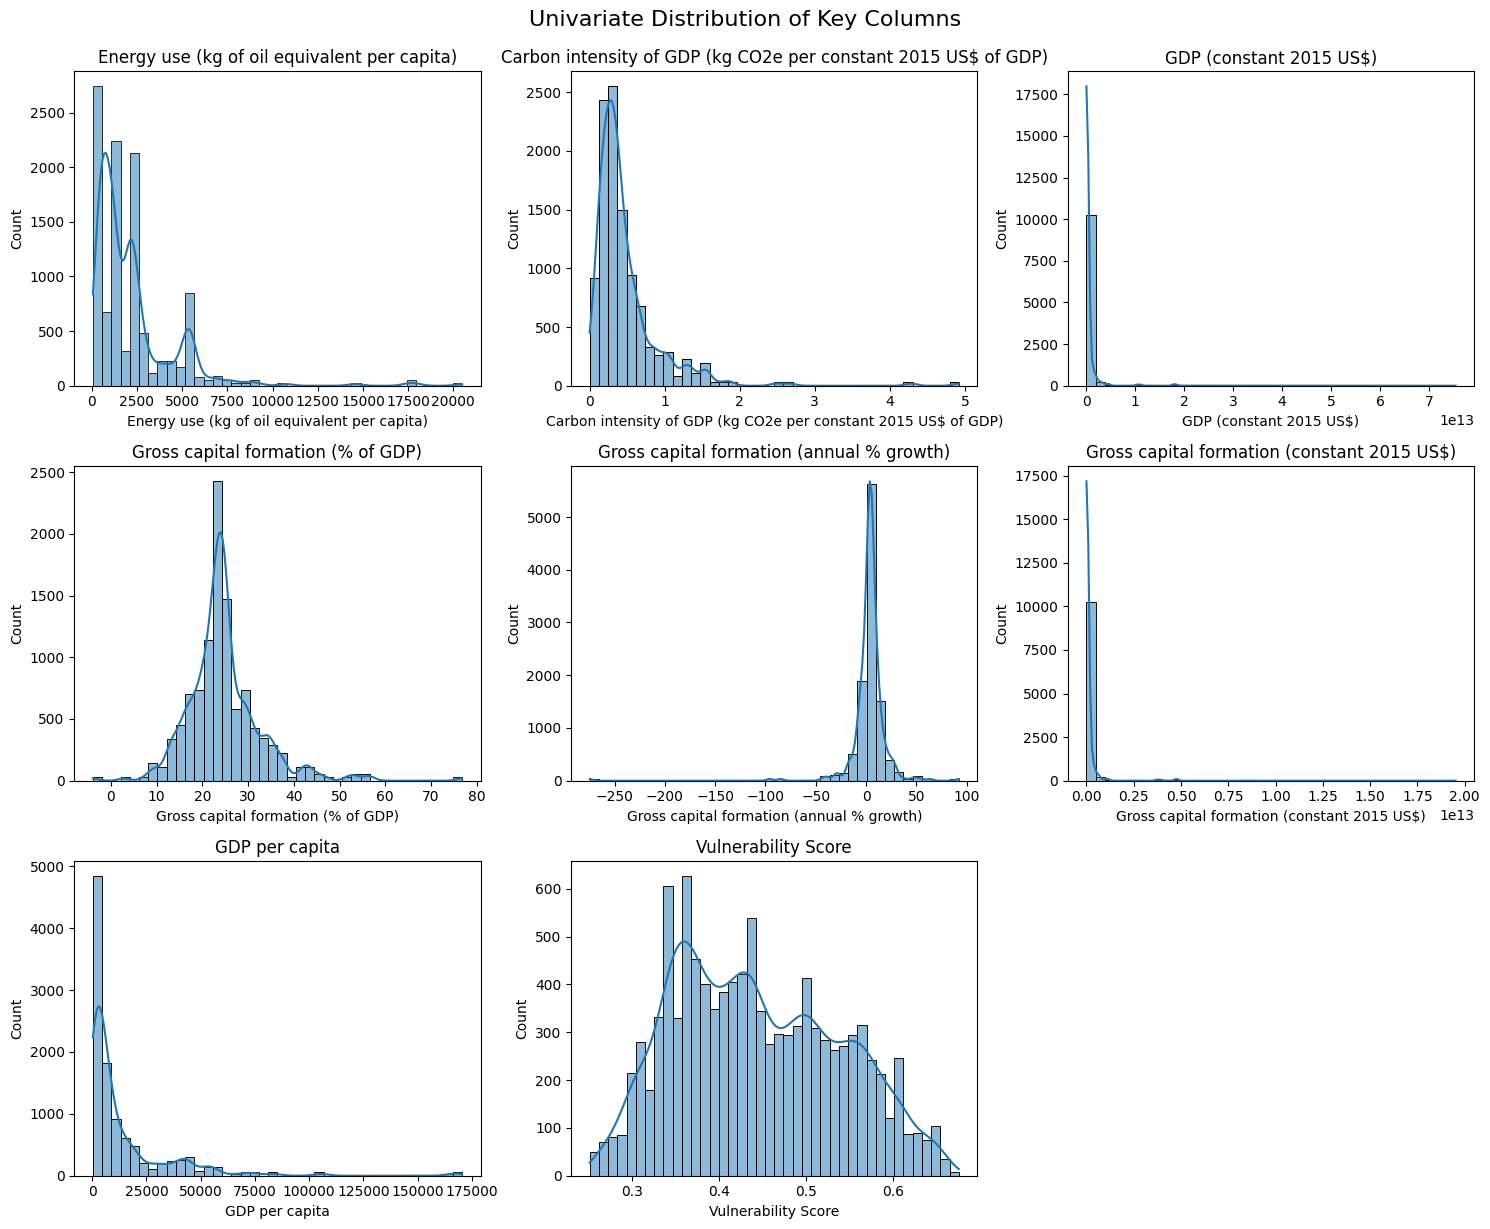

In [8]:
import seaborn as sns
key_cols = [
    "Energy use (kg of oil equivalent per capita)",
    "Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)",
    "GDP (constant 2015 US$)",
    "Gross capital formation (% of GDP)",
    "Gross capital formation (annual % growth)",
    "Gross capital formation (constant 2015 US$)",
    "GDP per capita",
    "Vulnerability Score",
]

# filter to relevant columns
df = c_df_range.copy()
df = df[key_cols].dropna()

# set up plot grid
n_cols = 3
n_rows = (len(key_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# loop over each column to plot
for i, col in enumerate(key_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(df[col], kde=True, bins=40)
    else:
        sns.countplot(x=col, data=df)
        plt.xticks(rotation=30)
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Univariate Distribution of Key Columns", fontsize=16, y=1.02)
plt.show()




In [9]:
import pandas as pd
columns_to_avg = [
    "Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)",
    "Electricity production from renewable sources, excluding hydroelectric (% of total)",
    "Energy use (kg of oil equivalent per capita)",
    "Fossil fuel energy consumption (% of total)",
    "GDP (constant 2015 US$)",
    "Gross capital formation (% of GDP)",
    "Gross capital formation (annual % growth)",
    "Gross capital formation (constant 2015 US$)",
    "Population, total",
    "energy_usage",
    "GDP per capita",
    "Vulnerability Score"
]

df_avg = filtered_df.groupby(["Country Name", "Country Code"], as_index=False)[columns_to_avg].mean()
df_avg = df_avg.rename(columns={"Gross capital formation (% of GDP)": "Gross_Capital_gdp_pct"})
df_avg = df_avg.rename(columns={"Gross capital formation (annual % growth)": "Gross_Capital_growth"})
df_avg.head(10)
df_avg.to_csv("cleaned_data.csv", index=False)



In [10]:


def normalise_and_compute_influence(df, alpha=0.5, beta=0.25, gamma=0.25):
    """
    Normalizes GDP, energy usage, and investment; computes country influence score.

    Parameters:
    - df: pandas DataFrame with raw economic data
    - alpha, beta, gamma: weights for GDP, energy usage, and investment respectively

    Returns:
    - df: modified DataFrame with normalized columns and influence score
    """
    df = df.copy()

    # normalize core metrics
    df["GDP_norm"] = df["GDP (constant 2015 US$)"] / df["GDP (constant 2015 US$)"].sum()
    df["investment_norm"] = df["Gross capital formation (constant 2015 US$)"] / df["Gross capital formation (constant 2015 US$)"].sum()
    df["energy_norm"] = df["energy_usage"] / df["energy_usage"].sum()

    # compute influence
    df["influence"] = (
        alpha * df["GDP_norm"] +
        beta * df["energy_norm"] +
        gamma * df["investment_norm"]
    )

    # normalize influence
    df["influence"] /= df["influence"].sum()

    return df


#electricity production from renewable sources, excluding hydroelectric (% of total
#country Code
#Energy use (kg of oil equivalent per capita)
#GDP (constant 2015 US$
#Gross_Capital_gdp_pct
#Gross_Capital_growth
#Gross capital formation (constant 2015 US$
#Population, total









# **Defining Payoff structure**



In [12]:
### INITIALISING STATIC PARTS

import numpy as np
df = df_norm.copy()

def compute_static_game_variables_v2(df, base_alpha=1.0, scaling_factor=100000, payoff_scale=10000):
    """
    Initializes all static variables for the game model.
    Includes:
    - alpha_i
    - gdp_penalty
    - C_0_i (initial cost)
    - C_t (initial round cost)
    - EconomicGains
    - ClimatePayoff
    - Pressure_0
    - Pressure_t

    Returns:
    - df: modified DataFrame with new static columns
    """
    df = df.copy()

    # carbon intensity (dirtiness) scaled
    max_ci = df["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"].max()
    df["alpha_i"] = base_alpha * (
        df["Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP)"] / max_ci
    )

    # development penalty
    gdp_ratio = df["GDP per capita"] / df["GDP per capita"].max()
    df["gdp_penalty"] = np.exp(-1 * gdp_ratio) + 1

    # cost of adoption
    df["C_0_i"] = (
        df["alpha_i"] *
        df["GDP_norm"] *
        (1 + df["Fossil fuel energy consumption (% of total)"] / 100) *
        df["gdp_penalty"]
    ) * scaling_factor 

    df["C_t"] = df["C_0_i"]

    # economic gains from green transition
    df["EconomicGains"] = (
        (1 - df["alpha_i"]) *
        df["GDP_norm"] *
        (1 - df["Fossil fuel energy consumption (% of total)"] / 100) 
    ) * scaling_factor

    # climate payoff
    df["ClimatePayoff"] = (
        (1 - df["Vulnerability Score"] / 100) *
        df["GDP_norm"] *
        payoff_scale
    )

    # initial pressure
    df["Pressure_0"] = (
        df["GDP_norm"] *
        (1 - df["alpha_i"]) *
        0.05 *
        scaling_factor
    )

    df["Pressure_t"] = df["Pressure_0"]

    df["Perceived_Climate_B"] = 0

    return df

df = compute_static_game_variables_v2(df)



In [ ]:
### INITIAL STRATEGY PROFILES AND GAME VARIABLES

def initialize_G_and_W_and_T(df, min_gdp_threshold, theta=0.6):
    df["G"] = ((df["EconomicGains"] > df["C_0_i"]) & 
               (df["GDP per capita"] > min_gdp_threshold)).astype(int)
    W_t = (df["G"] * df["influence"]).sum()
    T = theta * df['influence'].sum()
    return df, W_t, T
min_gdp_threshold = 5000
df, W_t, T = initialize_G_and_W_and_T(df, min_gdp_threshold)

df.head()

,Country Name,Country Code,Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP),"Electricity production from renewable sources, excluding hydroelectric (% of total)",Energy use (kg of oil equivalent per capita),Fossil fuel energy consumption (% of total),GDP (constant 2015 US$),Gross_Capital_gdp_pct,Gross_Capital_growth,Gross capital formation (constant 2015 US$),...,alpha_i,gdp_penalty,C_0_i,C_t,EconomicGains,ClimatePayoff,Pressure_0,Pressure_t,Perceived_Climate_B,G
0,Afghanistan,AFG,0.425567,2.000000,526.515421,98.000000,1.899736e+10,24.163367,6.954887,2.446039e+09,...,0.092451,1.996608,9.444031,9.444031,0.469017,2.568527,1.172541,1.172541,0,0
1,Albania,ALB,0.442280,0.000000,977.794832,79.710901,1.126327e+10,25.746871,-1.233273,2.900030e+09,...,0.096082,1.977010,5.229786,5.229786,2.809644,1.525267,0.692402,0.692402,0,0
2,Algeria,DZA,0.866250,0.055961,1232.571339,98.988958,1.845870e+11,49.339046,7.162873,9.114440e+10,...,0.188186,1.972623,185.462523,185.462523,2.060732,25.011372,10.191132,10.191132,0,0
3,American Samoa,ASM,0.000151,2.000000,2186.939243,98.000000,6.627252e+08,23.736130,2.849945,1.481547e+10,...,0.000033,1.928432,0.000113,0.000113,0.018028,0.089770,0.045070,0.045070,0,1
4,Andorra,AND,0.222601,2.000000,5372.539132,98.000000,2.770159e+09,22.991442,3.878227,6.705156e+10,...,0.048358,1.797524,0.648500,0.648500,0.071714,0.375491,0.179285,0.179285,0,0


In [ ]:
### DEFINING THE DYNAMIC PARTS
#method, define all the moving parts in each round for each country, then just use them as variables in a later payoff function.



# simulation parameters
N = 10                  # total rounds
t = 1

lambda_u = 1        # urgency growth exponent
gamma = 1.05            # pressure growth rate
Z = 0.2                 # cost reduction rate
threshold = 0.6         # cooperation threshold (W ≥ T)

U_t = (t / N) ** lambda_u
T_d = 1 if W_t >= T else 0



###COSTS
def compute_C_t(C_t, W_t, Z=0.4):
    """
    Return cost of adoption for all players, independent of their G status.
    Actual cost is only applied if a player adopts.
    """
    return C_t * (1 - Z * (1 + W_t))

df["C_t"] = compute_C_t(df["C_t"], W_t, Z)

###PRESSURE


def update_pressure(df, W_t, gamma=1.05):
    """
    Update country-specific pressure based on prior value and global adoption.

    Returns a pd.Series
    """
    return df["Pressure_t"] * (gamma * (1 + W_t))

update_pressure(df, W_t, gamma)
df.head()


###Perceived Climate Benefit
def compute_perceived_climate_benefit(df, T_d, U_t):
    """
    Compute perceived climate benefit at time t.

    Parameters:
    - df: DataFrame containing ClimatePayoff per country
    - T_d: threshold dummy (0 or 1)
    - U_t: urgency scalar at time t (e.g. (t / N)^λ)

    Returns:
    - Series of perceived climate benefits for each country
    """
    return (1 - T_d) * U_t * df["ClimatePayoff"] 


df["Perceived_Climate_B"] = compute_perceived_climate_benefit(df, T_d, U_t)

###Real Climate Benefits
def compute_real_climate_benefit(df, T_d):
    """
    Compute real climate benefit at time t.

    Parameters:
    - df: DataFrame containing ClimatePayoff per country
    - T_d: threshold dummy (0 or 1)

    Returns:
    - Series of real climate benefits for each country
    """
    return T_d * df["ClimatePayoff"]



def best_response(df, min_gdp_threshold=5000):
    return ((df["Payoff_if_adopt"] > df["Payoff_if_free_ride"]) & 
            (df["GDP per capita"] > min_gdp_threshold)).astype(int)




df.head()

,Country Name,Country Code,Carbon intensity of GDP (kg CO2e per constant 2015 US$ of GDP),"Electricity production from renewable sources, excluding hydroelectric (% of total)",Energy use (kg of oil equivalent per capita),Fossil fuel energy consumption (% of total),GDP (constant 2015 US$),Gross_Capital_gdp_pct,Gross_Capital_growth,Gross capital formation (constant 2015 US$),...,alpha_i,gdp_penalty,C_0_i,C_t,EconomicGains,ClimatePayoff,Pressure_0,Pressure_t,Perceived_Climate_B,G
0,Afghanistan,AFG,0.425567,2.000000,526.515421,98.000000,1.899736e+10,24.163367,6.954887,2.446039e+09,...,0.092451,1.996608,9.444031,7.220860,0.469017,2.568527,1.172541,1.172541,0.256853,0
1,Albania,ALB,0.442280,0.000000,977.794832,79.710901,1.126327e+10,25.746871,-1.233273,2.900030e+09,...,0.096082,1.977010,5.229786,3.998669,2.809644,1.525267,0.692402,0.692402,0.152527,0
2,Algeria,DZA,0.866250,0.055961,1232.571339,98.988958,1.845870e+11,49.339046,7.162873,9.114440e+10,...,0.188186,1.972623,185.462523,141.803751,2.060732,25.011372,10.191132,10.191132,2.501137,0
3,American Samoa,ASM,0.000151,2.000000,2186.939243,98.000000,6.627252e+08,23.736130,2.849945,1.481547e+10,...,0.000033,1.928432,0.000113,0.000086,0.018028,0.089770,0.045070,0.045070,0.008977,1
4,Andorra,AND,0.222601,2.000000,5372.539132,98.000000,2.770159e+09,22.991442,3.878227,6.705156e+10,...,0.048358,1.797524,0.648500,0.495840,0.071714,0.375491,0.179285,0.179285,0.037549,0


# **Simulation Logic**

In [15]:
def run_simulation(df, N=10, lambda_u=1, gamma=1.05, Z=0.1, theta=0.8, min_gdp_threshold=5000):
    """
    Simulates N rounds of the Climate Catastrophe Game.

    Parameters:
    - df: initialized DataFrame with all static variables
    - N: number of rounds
    - lambda_u: urgency growth exponent
    - gamma: pressure growth rate
    - Z: cost reduction rate from global adoption
    - theta: adoption threshold proportion of total influence
    - min_gdp_threshold: GDP per capita cutoff for eligibility to adopt

    Returns:
    - history: list of DataFrames, one per round with key metrics
    """
    df = compute_static_game_variables_v2(df)
    df = normalise_and_compute_influence(df)
    df, W_t, T = initialize_G_and_W_and_T(df, min_gdp_threshold, theta)

    history = []

    for t in range(1, N + 1):
        # compute urgency and threshold dummy
        U_t = (t / N) ** lambda_u
        T_d = 1 if W_t >= T else 0

        # update moving variables
        df["C_t"] = compute_C_t(df["C_0_i"], W_t, Z)
        df["Pressure_t"] = update_pressure(df, W_t, gamma)
        df["Perceived_Climate_B"] = compute_perceived_climate_benefit(df, T_d, U_t)
        df["Real_Climate_B"] = compute_real_climate_benefit(df, T_d)

        # compute payoffs
        df["Payoff_if_adopt"] = (
            df["EconomicGains"] + df["Perceived_Climate_B"] + df["Real_Climate_B"] - df["C_t"]
        )
        df["Payoff_if_free_ride"] = (
            - df["Pressure_t"] + df["Real_Climate_B"] 
        )

        # update strategies
        df["G"] = best_response(df, min_gdp_threshold)

        # update W_t based on new adoptions
        W_t = (df["G"] * df["influence"]).sum()

        # snapshot state for this round
        snapshot = df.copy()
        snapshot["round"] = t
        snapshot["W_t"] = W_t
        snapshot["U_t"] = U_t
        snapshot["T_d"] = T_d

        history.append(snapshot[[
            "round", "Country Name", "G", "W_t", "U_t", "T_d",
            "C_t", "EconomicGains", "Pressure_t",
            "Perceived_Climate_B", "Real_Climate_B",
            "Payoff_if_adopt", "Payoff_if_free_ride"
        ]])

    return history





# **Equilibria Simulations and plots for Streamlit**

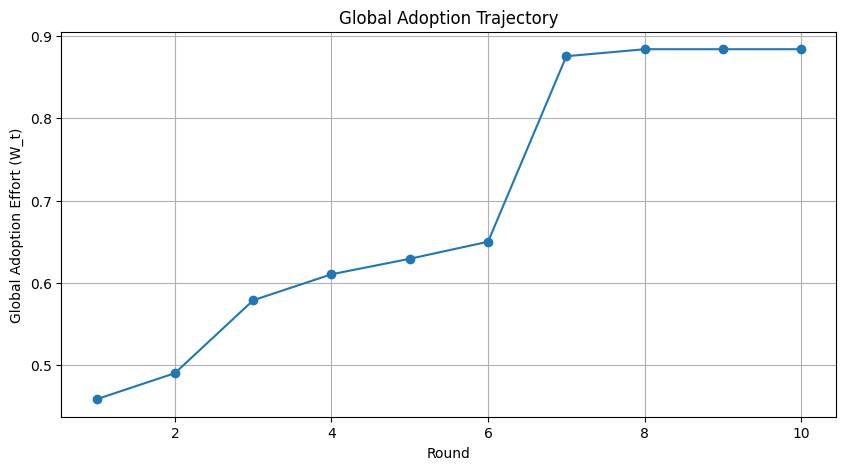

In [ ]:
import matplotlib.pyplot as plt

history = run_simulation(df, N=10)
results = pd.concat(history, ignore_index=True)
global_adoption = results.groupby("round")["W_t"].mean()

plt.figure(figsize=(10, 5))
plt.plot(global_adoption.index, global_adoption.values, marker='o')
plt.xlabel("Round")
plt.ylabel("Global Adoption Effort (W_t)")
plt.title("Global Adoption Trajectory")
plt.grid(True)
plt.show()

###Plot showing Crossed Threshold Equilibrium

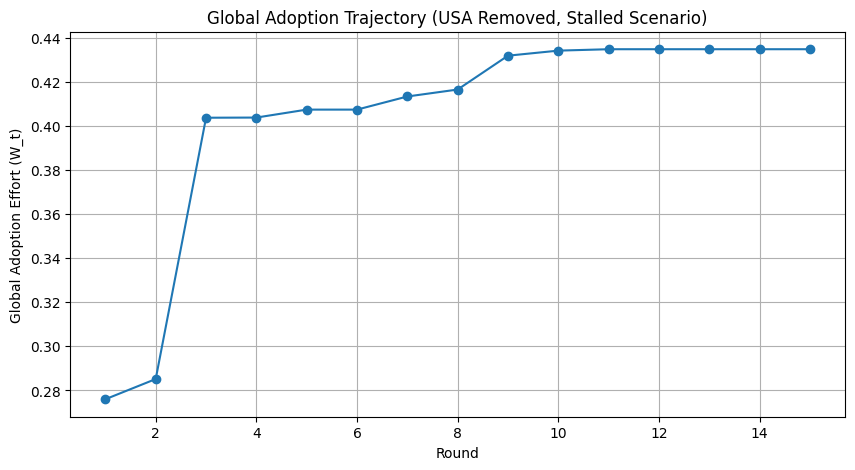

In [17]:
# remove usa from the dataset
df_no_usa = df[df["Country Name"] != "United States"].copy()

# run simulation with tuned parameters to suppress transition
history = run_simulation(
    df_no_usa,
    N=15,
    lambda_u=0.4,          # low urgency
    gamma=1,            # low pressure scaling
    Z=0.05,                # minimal cost drops
    theta=0.8,             # high threshold
    min_gdp_threshold=15000  # fewer eligible adopters
)

# visualize global adoption over time
results = pd.concat(history, ignore_index=True)
global_adoption = results.groupby("round")["W_t"].mean()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(global_adoption.index, global_adoption.values, marker='o')
plt.xlabel("Round")
plt.ylabel("Global Adoption Effort (W_t)")
plt.title("Global Adoption Trajectory (USA Removed, Stalled Scenario)")
plt.grid(True)
plt.show()

###Plot showing free-roder dominance equilbrium

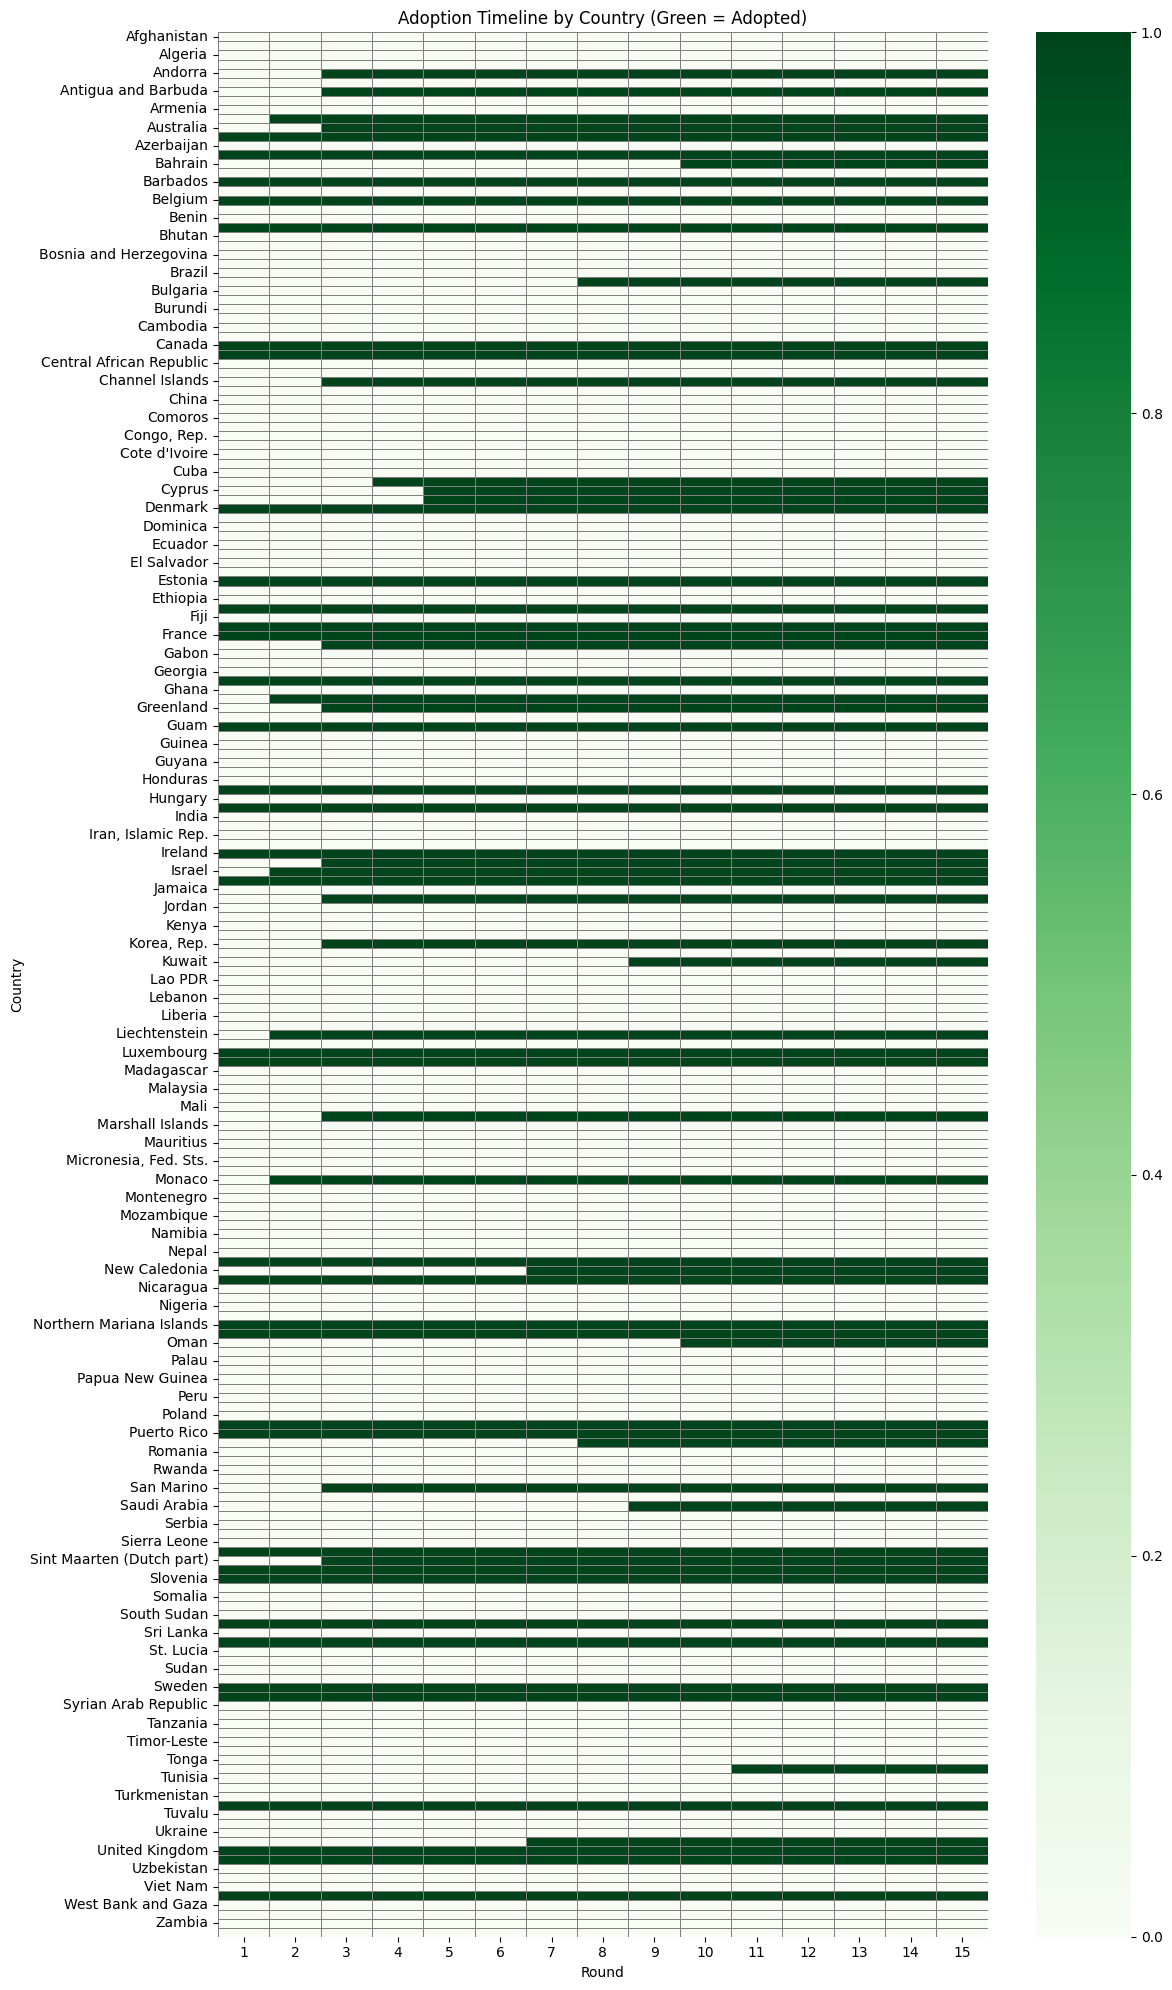

In [ ]:
import seaborn as sns

pivot = results.pivot(index="Country Name", columns="round", values="G").fillna(0)

plt.figure(figsize=(12, 20))
sns.heatmap(pivot, cmap="Greens", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Adoption Timeline by Country (Green = Adopted)")
plt.xlabel("Round")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

### Adoption heatmap maybe include into streamlit?

In [ ]:
### Thanks for looking at this